In [255]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import ast
import matplotlib.patches as mpatches
from scipy.stats import t
from itertools import combinations
from math import factorial

In [245]:
def stripper(x, length):
    dummy = []
    for i in x.strip().strip('[]').split():
        single = i.strip('\n')
        if single.isspace():
            continue
        if len(single) == 0:
            continue
        try:
            temp = float(single)
            dummy.append(temp)
        except:
            print(f"Warning: Couldn't convert {single} to float.")
    if len(dummy) != length:
        print(f"Warning: Only {len(dummy)} values were converted.")
    return dummy

In [ ]:
def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes two-sided paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = 2 * t.sf(np.abs(t_stat), df)  # two-sided t-test
    return t_stat, p_val

In [200]:
combinations = ['RRP', 'RPP', 'RPR', 'RRR', 'SRP', 'SPP', 'SPR', 'SRR']
thresholds = [0.95, 0.98, 1.0]
III14 = pd.DataFrame(index=thresholds, columns=combinations)
III14_err = pd.DataFrame(index=thresholds, columns=combinations)
III14_vec = pd.DataFrame(index=thresholds, columns=combinations)
C1 = pd.DataFrame(index=thresholds, columns=combinations)
C1_err = pd.DataFrame(index=thresholds, columns=combinations)
C1_vec = pd.DataFrame(index=thresholds, columns=combinations)
C28 = pd.DataFrame(index=thresholds, columns=combinations)
C28_err = pd.DataFrame(index=thresholds, columns=combinations)
C28_vec = pd.DataFrame(index=thresholds, columns=combinations)
result_dir="/home/breuter/MalariaVaccineEfficacyPrediction/results"
for threshold in thresholds:
    maindir = f"{result_dir}/threshold{threshold}/multitaskSVM"
    for combination in combinations:
        ana_dir = f"{maindir}/whole/{combination}/RNCV"
        fn = os.path.join(ana_dir, "collected_key_results.tsv")
        temp =  pd.read_csv(fn, sep='\t', index_col=0)
        III14.loc[threshold, combination] = temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]
        C1.loc[threshold, combination] = temp.loc[temp['time'].isin(['C-1']), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]
        C28.loc[threshold, combination] = temp.loc[temp['time'].isin(['C28']), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]

        III14_err.loc[threshold, combination] = np.std(stripper(temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0]), ddof=1)
        C1_err.loc[threshold, combination] = np.std(stripper(temp.loc[temp['time'].isin(['C-1']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0]), ddof=1)
        C28_err.loc[threshold, combination] = np.std(stripper(temp.loc[temp['time'].isin(['C28']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0]), ddof=1)

        III14_vec.loc[threshold, combination] = stripper(temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0])
        C1_vec.loc[threshold, combination] = stripper(temp.loc[temp['time'].isin(['C-1']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0])
        C28_vec.loc[threshold, combination] = stripper(temp.loc[temp['time'].isin(['C28']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0])

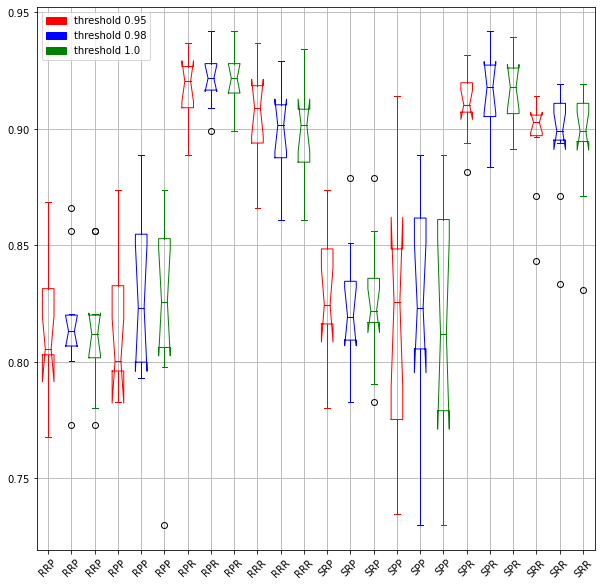

In [204]:
III14_vec.transpose()[0.95].apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(1, 25, 3), notch=True, color='r', labels=['0.95' for x in range(0, 8)])
III14_vec.transpose()[0.98].apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(2, 25, 3), notch=True, color='b', labels=['0.98' for x in range(0, 8)])
III14_vec.transpose()[1.0].apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(3, 25, 3), notch=True, color='g', labels=['1.0' for x in range(0, 8)])
red_patch = mpatches.Patch(color='red', label='threshold 0.95')
blue_patch = mpatches.Patch(color='blue', label='threshold 0.98')
green_patch = mpatches.Patch(color='green', label='threshold 1.0')
plt.legend(handles=[red_patch, blue_patch, green_patch])
plt.show()
plt.close()

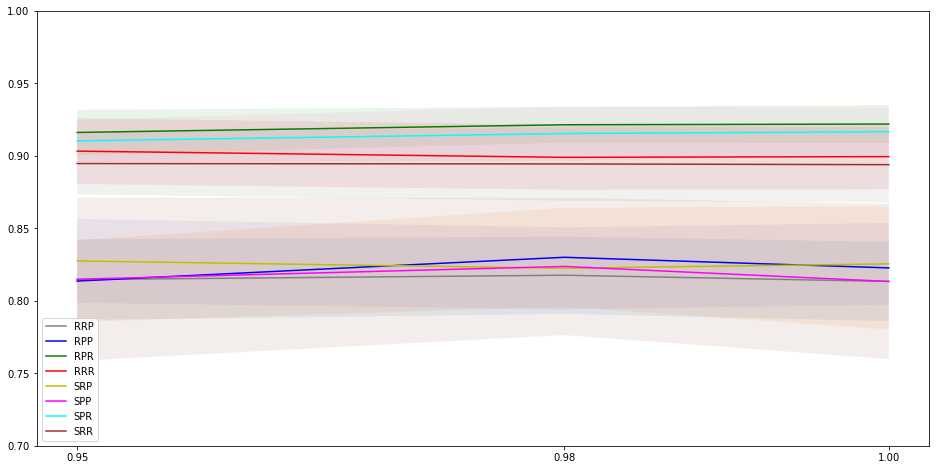

In [206]:
colors=['gray','b','g','r','y','magenta','cyan','brown']
plt.figure(figsize=(16, 8))
for column, color in zip(III14.columns, colors):
    plt.plot(III14.index, III14[column], color=color, label=column)
    plt.fill_between(III14.index, III14[column].to_numpy(dtype=float) - III14_err[column].to_numpy(dtype=float), III14[column].to_numpy(dtype=float) + III14_err[column].to_numpy(dtype=float), alpha=0.1)
    plt.ylim((0.7, 1))
    plt.xticks(III14.index)
    plt.legend()
plt.show()
plt.close()

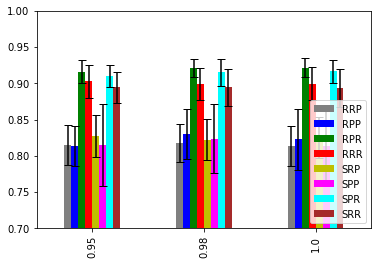

In [205]:
III14.plot(kind='bar', yerr=III14_err, capsize=4, color=['gray','b','g','r','y','magenta','cyan','brown'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

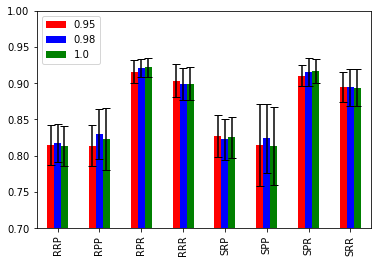

In [209]:
III14.transpose().plot(kind='bar', yerr=III14_err.transpose(), capsize=4, color=['r', 'b', 'g'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

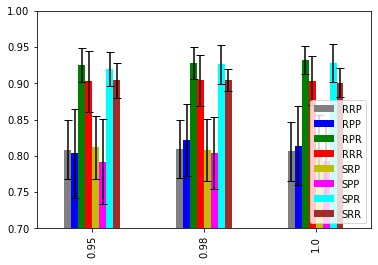

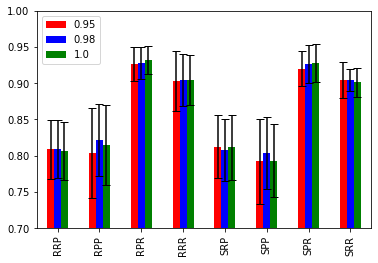

In [210]:
C1.plot(kind='bar', yerr=C1_err, capsize=4, color=['gray','b','g','r','y','magenta','cyan','brown'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

C1.transpose().plot(kind='bar', yerr=C1_err.transpose(), capsize=4, color=['r', 'b', 'g'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

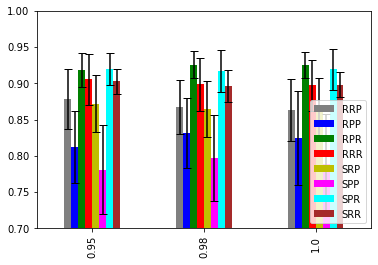

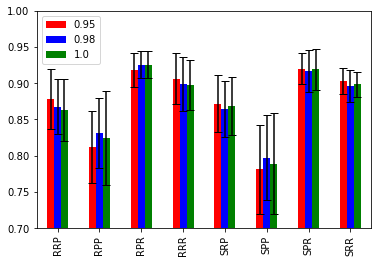

In [211]:
C28.plot(kind='bar', yerr=C28_err, capsize=4, color=['gray','b','g','r','y','magenta','cyan','brown'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

C28.transpose().plot(kind='bar', yerr=C28_err.transpose(), capsize=4, color=['r', 'b', 'g'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

In [214]:
combinations = ['RRP', 'RPP', 'RPR', 'RRR', 'SRP', 'SPP', 'SPR', 'SRR']
thresholds = [0.95, 0.98, 1.0]
III14s = pd.DataFrame(index=thresholds, columns=combinations)
C1s = pd.DataFrame(index=thresholds, columns=combinations)
C28s = pd.DataFrame(index=thresholds, columns=combinations)
III14s_err = pd.DataFrame(index=thresholds, columns=combinations)
C1s_err = pd.DataFrame(index=thresholds, columns=combinations)
C28s_err = pd.DataFrame(index=thresholds, columns=combinations)
result_dir="/home/breuter/MalariaVaccineEfficacyPrediction/results"
for threshold in thresholds:
    maindir = f"{result_dir}/threshold{threshold}/multitaskSVM"
    for combination in combinations:
        ana_dir = f"{maindir}/whole/{combination}/RNCV"
        fn = os.path.join(ana_dir, "collected_key_results.tsv")
        temp =  pd.read_csv(fn, sep='\t', index_col=0)
        III14s.loc[threshold, combination] = temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]
        C1s.loc[threshold, combination] = temp.loc[temp['time'].isin(['C-1']), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]
        C28s.loc[threshold, combination] = temp.loc[temp['time'].isin(['C28']), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]
        III14s_err.loc[threshold, combination] = np.std(stripper(temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0]), ddof=1)
        C1s_err.loc[threshold, combination] = np.std(stripper(temp.loc[temp['time'].isin(['C-1']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0]), ddof=1)
        C28s_err.loc[threshold, combination] = np.std(stripper(temp.loc[temp['time'].isin(['C28']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0]), ddof=1)

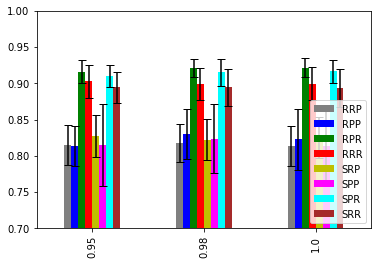

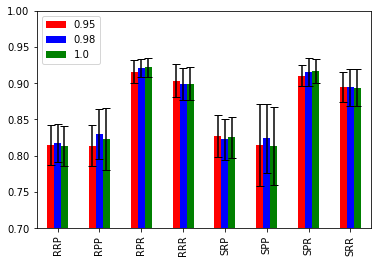

In [215]:
III14s.plot(kind='bar', yerr=III14s_err, capsize=4, color=['gray','b','g','r','y','magenta','cyan','brown'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

III14s.transpose().plot(kind='bar', yerr=III14s_err.transpose(), capsize=4, color=['r', 'b', 'g'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

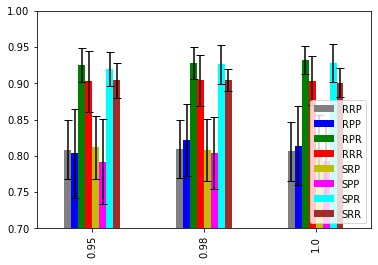

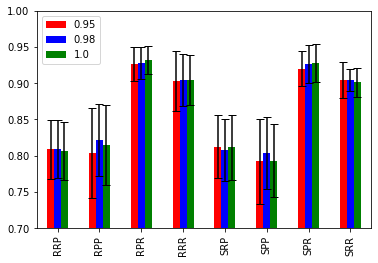

In [216]:
C1s.plot(kind='bar', yerr=C1s_err, capsize=4, color=['gray','b','g','r','y','magenta','cyan','brown'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

C1s.transpose().plot(kind='bar', yerr=C1s_err.transpose(), capsize=4, color=['r', 'b', 'g'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

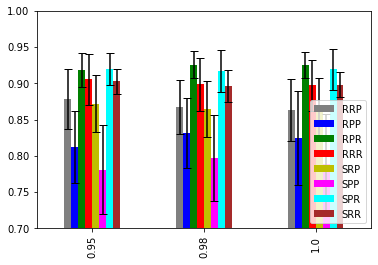

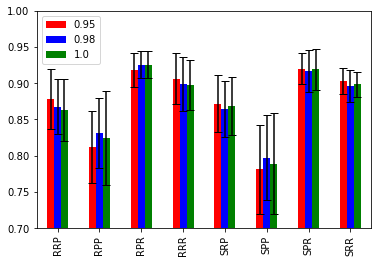

In [217]:
C28s.plot(kind='bar', yerr=C28s_err, capsize=4, color=['gray','b','g','r','y','magenta','cyan','brown'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

C28s.transpose().plot(kind='bar', yerr=C28s_err.transpose(), capsize=4, color=['r', 'b', 'g'])
plt.ylim((0.7, 1))
plt.legend()
plt.show()
plt.close()

In [316]:
combis = ['RRP', 'RPP', 'RPR', 'RRR', 'SRP', 'SPP', 'SPR', 'SRR']
thresholds = [0.95, 0.98, 1.0]
methods = ['RF', 'RLR', 'SVM', 'multitaskSVM']
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'SRP', 'SPP', 'SPR', 'SRR']
times = ['III14', 'C-1', 'C28']
results = {
    'whole': {
        'III14_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_std': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_std': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C28_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C28_std': pd.DataFrame(index=thresholds, columns=columns),
        'C28_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C28_test': pd.DataFrame(index=thresholds, columns=columns),
    },
    'selective': {
        'III14_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_std': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_std': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C28_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C28_std': pd.DataFrame(index=thresholds, columns=columns),
        'C28_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C28_test': pd.DataFrame(index=thresholds, columns=columns),
    },
}
result_dir="/home/breuter/MalariaVaccineEfficacyPrediction/results"

for threshold in thresholds:
    for method in methods:
        maindir = f"{result_dir}/threshold{threshold}/{method}"
        for dataset in ['whole', 'selective']:
            if method == 'multitaskSVM':
                for combination in combis:
                    ana_dir = f"{maindir}/{dataset}/{combination}/RNCV"
                    fn = os.path.join(ana_dir, "collected_key_results.tsv")
                    try:
                        temp =  pd.read_csv(fn, sep='\t', index_col=0)
                    except:
                        print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, combination={combination}.")
                        continue
                    for time in times:
                        results[dataset][f'{time}_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]

                        results[dataset][f'{time}_std'].loc[threshold, combination] = np.std(stripper(temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10), ddof=1)

                        results[dataset][f'{time}_ncv'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10)

                        results[dataset][f'{time}_test'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50)

            else:
                ana_dir = f"{maindir}/{dataset}/RNCV"
                fn = os.path.join(ana_dir, "collected_key_results.tsv")
                try:
                    temp =  pd.read_csv(fn, sep='\t', index_col=0)
                except:
                    print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}.")
                    continue
                for time in times:
                    results[dataset][f'{time}_mean'].loc[threshold, method] = temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]

                    results[dataset][f'{time}_std'].loc[threshold, method] = np.std(stripper(temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10), ddof=1)

                    results[dataset][f'{time}_ncv'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10)

                    results[dataset][f'{time}_test'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin(['III14']), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50)

No results found for threshold=1.0, method=RLR, dataset=whole.


In [317]:
results['whole']['III14_ncv']

,RF,RLR,SVM,RRP,RPP,RPR,RRR,SRP,SPP,SPR,SRR
0.95,"[0.73484848, 0.70580808, 0.73737374, 0.7361111...","[0.85606061, 0.71212121, 0.87121212, 0.7803030...","[0.53030303, 0.59343434, 0.67171717, 0.5252525...","[0.83838384, 0.8030303, 0.80555556, 0.86868687...","[0.79545455, 0.83838384, 0.83838384, 0.8737373...","[0.92171717, 0.91919192, 0.92676768, 0.8888888...","[0.91919192, 0.89393939, 0.90909091, 0.9368686...","[0.8510101, 0.82575758, 0.82323232, 0.87373737...","[0.73484848, 0.85353535, 0.82828283, 0.9141414...","[0.90909091, 0.92171717, 0.93181818, 0.8939393...","[0.9040404, 0.8989899, 0.90656566, 0.89646465,..."
0.98,"[0.77272727, 0.70454545, 0.76641414, 0.7070707...","[0.85606061, 0.70707071, 0.89393939, 0.7777777...","[0.58207071, 0.57323232, 0.68686869, 0.5025252...","[0.85606061, 0.81818182, 0.81565657, 0.8661616...","[0.79545455, 0.88888889, 0.84343434, 0.8712121...","[0.92424242, 0.91919192, 0.93434343, 0.9166666...","[0.9040404, 0.8989899, 0.90656566, 0.92929293,...","[0.8510101, 0.81565657, 0.82323232, 0.87878788...","[0.81313131, 0.86616162, 0.82575758, 0.8888888...","[0.92171717, 0.91919192, 0.93686869, 0.8838383...","[0.8989899, 0.8989899, 0.91414141, 0.89393939,..."
1.00,"[0.76893939, 0.7020202, 0.75883838, 0.72474747...",NaN,"[0.64015152, 0.55050505, 0.62626263, 0.5025252...","[0.85606061, 0.81818182, 0.81565657, 0.8560606...","[0.72979798, 0.87373737, 0.82828283, 0.8712121...","[0.92424242, 0.91919192, 0.93939394, 0.9191919...","[0.9040404, 0.8989899, 0.90656566, 0.93434343,...","[0.85606061, 0.82828283, 0.82323232, 0.8787878...","[0.74747475, 0.86616162, 0.82070707, 0.8888888...","[0.92424242, 0.91919192, 0.93686869, 0.8939393...","[0.8989899, 0.8989899, 0.91414141, 0.89393939,..."


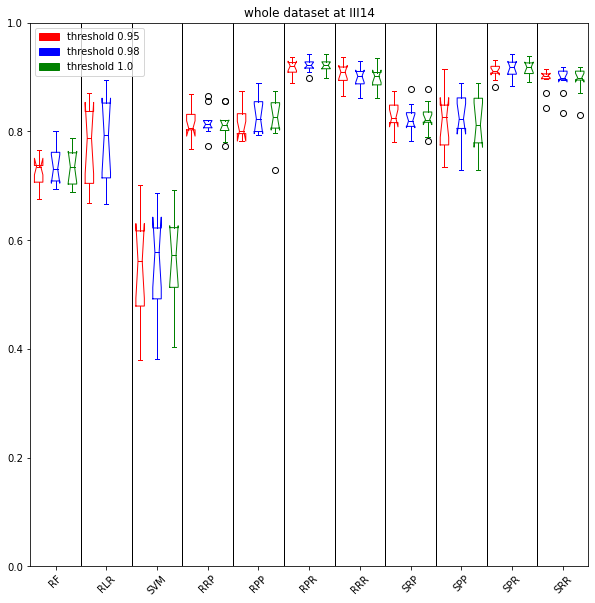

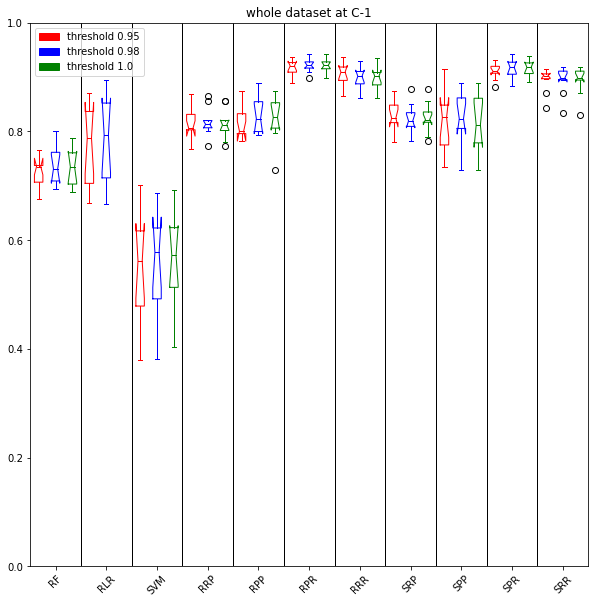

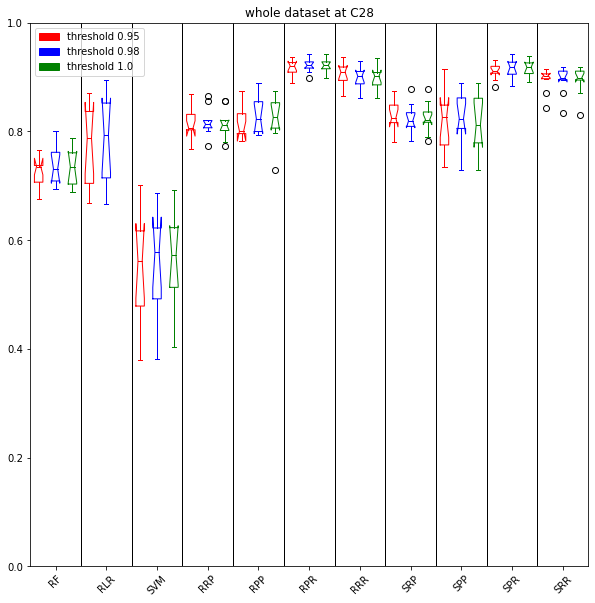

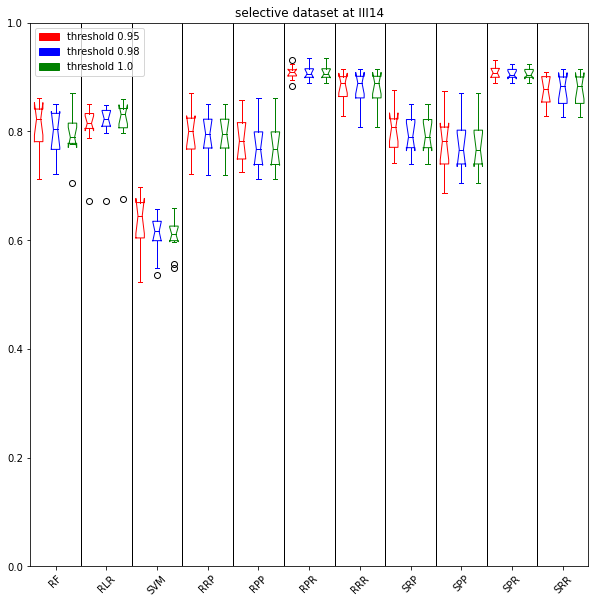

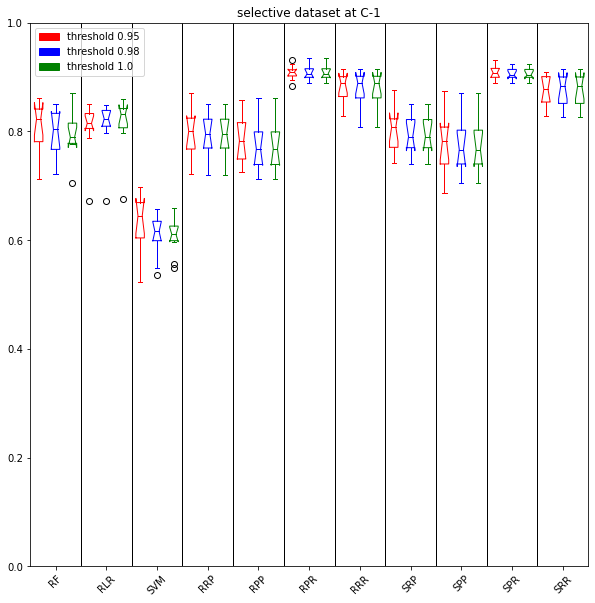

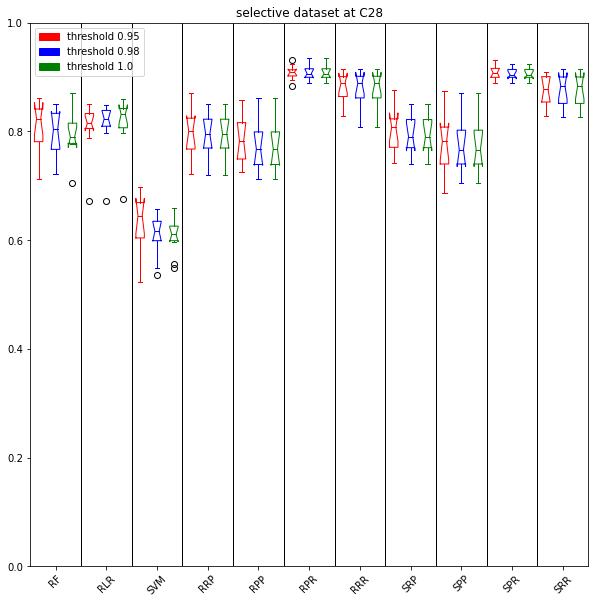

In [318]:
for dataset in ['whole', 'selective']:
    for time in times:
        results[dataset][f'{time}_ncv'].transpose()[0.95].apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(1, 34, 3), notch=True, color='r', labels=['0.95' for x in range(0, 11)], grid=False)
        results[dataset][f'{time}_ncv'].transpose()[0.98].apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(2, 34, 3), notch=True, color='b', labels=['0.98' for x in range(0, 11)], grid=False)
        results[dataset][f'{time}_ncv'].transpose()[1.0].apply(lambda x: pd.Series(x)).T.boxplot(figsize=(10,10),rot=45, positions=range(3, 34, 3), notch=True, color='g', labels=['1.0' for x in range(0, 11)], grid=False)
        red_patch = mpatches.Patch(color='red', label='threshold 0.95')
        blue_patch = mpatches.Patch(color='blue', label='threshold 0.98')
        green_patch = mpatches.Patch(color='green', label='threshold 1.0')
        for i in range(3, 34, 3):
            plt.vlines(i + 0.5, 0, 1, linewidth=1, color='k')
        plt.xticks(np.arange(2, 33, 3))
        plt.ylim((0, 1))
        plt.legend(handles=[red_patch, blue_patch, green_patch])
        plt.title(f"{dataset} dataset at {time}")
        plt.show()
        plt.close()

In [320]:
n = 50  # number of test sets
df = n - 1
n_train = 96
n_test = 8

for dataset in ['whole', 'selective']:
    for time in times:

        model_scores = pd.DataFrame(results[dataset][f'{time}_test'].loc[0.95, ['RPR', 'RRR', 'RRP', 'RPP']], index=['RPR', 'RRR', 'RRP', 'RPP'])

        n_comparisons = factorial(len(model_scores)) / (
            factorial(2) * factorial(len(model_scores) - 2)
        )
        pairwise_t_test = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
            p_val *= n_comparisons  # implement Bonferroni correction
            # Bonferroni can output p-values higher than 1
            p_val = 1 if p_val > 1 else p_val
            pairwise_t_test.append(
                [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
            )

        pairwise_comp_df = pd.DataFrame(
            pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
        ).round(3)


        rope_interval = [-0.01, 0.01]

        pairwise_bayesian = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_post = t(
                df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
            )
            worse_prob = t_post.cdf(rope_interval[0])
            better_prob = 1 - t_post.cdf(rope_interval[1])
            rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

            pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

        pairwise_bayesian_df = pd.DataFrame(
            pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
        ).round(3)

        pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
        print(dataset, time)
        print(pairwise_comp_df)
        print('')

whole III14
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR     RRR   0.520  1.000       0.158        0.511      0.330
1     RPR     RRP   3.101  0.019       0.001        0.997      0.002
2     RPR     RPP   2.384  0.126       0.006        0.982      0.013
3     RRR     RRP   2.928  0.031       0.001        0.995      0.004
4     RRR     RPP   2.047  0.276       0.014        0.962      0.024
5     RRP     RPP  -0.479  1.000       0.595        0.239      0.166

whole C-1
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR     RRR   0.520  1.000       0.158        0.511      0.330
1     RPR     RRP   3.101  0.019       0.001        0.997      0.002
2     RPR     RPP   2.384  0.126       0.006        0.982      0.013
3     RRR     RRP   2.928  0.031       0.001        0.995      0.004
4     RRR     RPP   2.047  0.276       0.014        0.962      0.024
5     RRP     RPP  -0.479  1.000       0.595        0.239      0.166

whole C28


In [321]:
n = 50  # number of test sets
df = n - 1
n_train = 32 # number of samples in a single timepoint train set (since the corrected variance decreases with increasing train set size, choosing the smaller of the two train set sizes - 32 for a single timepoint vs. 96 for all timepoints - is a conservative guess.)
n_test = 8

for dataset in ['whole', 'selective']:
    for time in times:

        model_scores = pd.DataFrame(results[dataset][f'{time}_test'].loc[0.95, ['RPR', 'RF', 'RLR', 'SVM']], index=['RPR', 'RF', 'RLR', 'SVM'])

        n_comparisons = factorial(len(model_scores)) / (
            factorial(2) * factorial(len(model_scores) - 2)
        )
        pairwise_t_test = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
            p_val *= n_comparisons  # implement Bonferroni correction
            # Bonferroni can output p-values higher than 1
            p_val = 1 if p_val > 1 else p_val
            pairwise_t_test.append(
                [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
            )

        pairwise_comp_df = pd.DataFrame(
            pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
        ).round(3)


        rope_interval = [-0.01, 0.01]

        pairwise_bayesian = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_post = t(
                df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
            )
            worse_prob = t_post.cdf(rope_interval[0])
            better_prob = 1 - t_post.cdf(rope_interval[1])
            rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

            pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

        pairwise_bayesian_df = pd.DataFrame(
            pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
        ).round(3)

        pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
        print(dataset, time)
        print(pairwise_comp_df)
        print('')

whole III14
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR      RF   2.254  0.172       0.010        0.980      0.010
1     RPR     RLR   1.350  1.000       0.072        0.884      0.044
2     RPR     SVM   3.154  0.016       0.001        0.998      0.001
3      RF     RLR  -0.936  1.000       0.783        0.142      0.075
4      RF     SVM   1.700  0.572       0.042        0.946      0.012
5     RLR     SVM   2.079  0.257       0.019        0.975      0.006

whole C-1
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR      RF   2.254  0.172       0.010        0.980      0.010
1     RPR     RLR   1.350  1.000       0.072        0.884      0.044
2     RPR     SVM   3.154  0.016       0.001        0.998      0.001
3      RF     RLR  -0.936  1.000       0.783        0.142      0.075
4      RF     SVM   1.700  0.572       0.042        0.946      0.012
5     RLR     SVM   2.079  0.257       0.019        0.975      0.006

whole C28
